# Overview

Home Credit社は、1997年にチェコ共和国で設立され、オランダに本社を置く国際的なノンバンク金融機関である。<br>
同社は10か国で事業を展開しており、主に信用履歴がない人々への分割払いに重点を置いている。<br>
今回は、顧客情報と返済情報をもとに、新たな顧客の返済リスクの有無を予測するモデルを作成する。

# Module

In [1]:
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Dataset

メインデータセットはapplication.csvであり、それに紐づいていくつかのサブデータセットが用意されている。<br>
今回使用するデータセットについて、いくつか中身を見ていく。

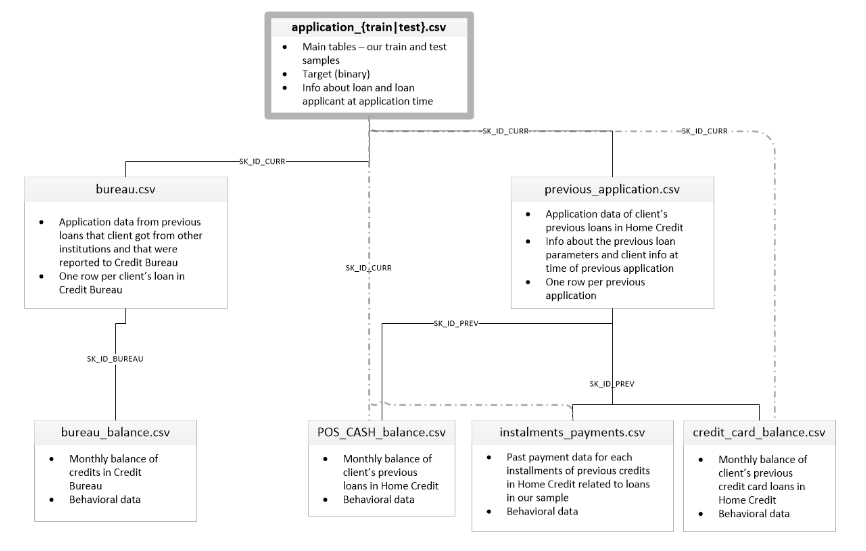

・application_{train|test}.csv：Home Credit社が持つデータで、返済リスクの有無とそれに対応する顧客の個人情報がまとめられているデータ<br>
・bureau.csv：Home Credit社以外での融資情報<br>
・POS_CASH_balance.csv：bureauの負債残高の履歴<br>
・credit_card_balance.csv：クレジットカードの使用に関する情報<br>
・previous_application.csv：Home Credit社における過去の融資情報

In [2]:
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

print(train.shape)
print(train.isnull().sum().sum())
train.head()

(307511, 122)
9152465


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


目的変数はTARGETであり、値は以下の2つが与えられている。

・0：返済リスクなし<br>
・1：過去に支払いの遅延があり、返済リスクあり

In [3]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [4]:
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')

print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [7]:
ccb = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
print(ccb.shape)
ccb.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [8]:
ccb.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [9]:
balance = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')

print(balance.shape)
balance.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [10]:
balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [11]:
previous = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')

print(previous.shape)
previous.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

# Visualization

各特徴量（顧客情報）に対する目的変数（TARGET）の分布を見ていく。

In [13]:
sns.set()

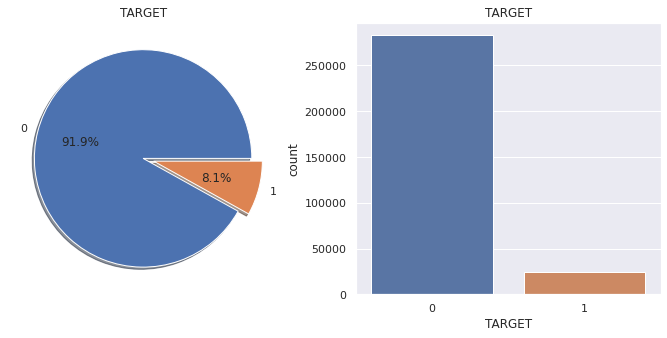

In [14]:
# 目的変数（0:返済リスクなし、1：返済困難）
figure ,ax = plt.subplots(1, 2, figsize=(12,5))

train['TARGET'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('TARGET')
ax[0].set_ylabel('')

sns.countplot(x='TARGET', data=train, ax=ax[1])
ax[1].set_title('TARGET')

plt.show()

<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

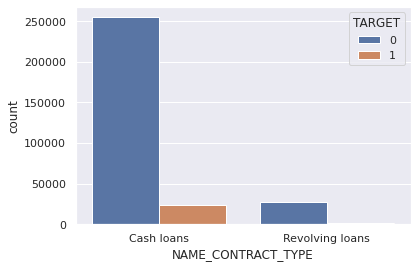

In [15]:
# ローンのタイプ
sns.countplot(x='NAME_CONTRACT_TYPE', data=train, hue='TARGET')

<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

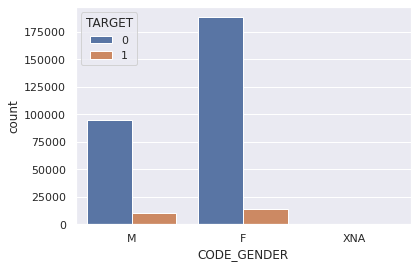

In [16]:
# 性別
sns.countplot(x='CODE_GENDER', data=train, hue='TARGET')

<AxesSubplot:xlabel='FLAG_OWN_CAR', ylabel='count'>

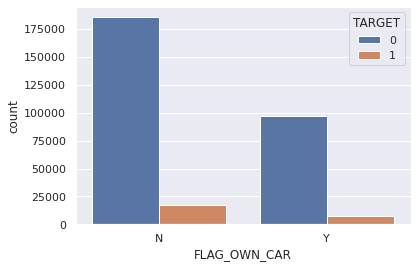

In [17]:
# 車所有の有無
sns.countplot(x='FLAG_OWN_CAR', data=train, hue='TARGET')

<AxesSubplot:xlabel='CNT_CHILDREN', ylabel='count'>

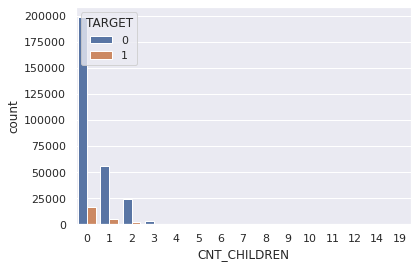

In [18]:
# 子供の人数
sns.countplot(x='CNT_CHILDREN', data=train, hue='TARGET')

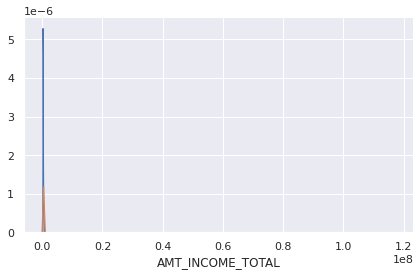

In [19]:
# 1年間の収入合計
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=1.5)
fig.map(sns.kdeplot, 'AMT_INCOME_TOTAL', shade=True)

外れ値が含まれている可能性が高い。

<AxesSubplot:xlabel='FLAG_OWN_REALTY', ylabel='count'>

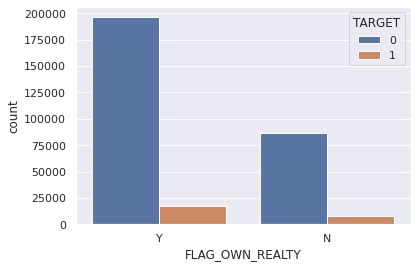

In [20]:
# 家所有の有無
sns.countplot(x='FLAG_OWN_REALTY', data=train, hue='TARGET')

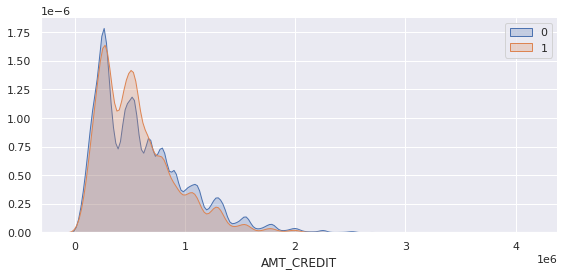

In [21]:
# ローン総額
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_CREDIT', shade=True)
plt.legend()

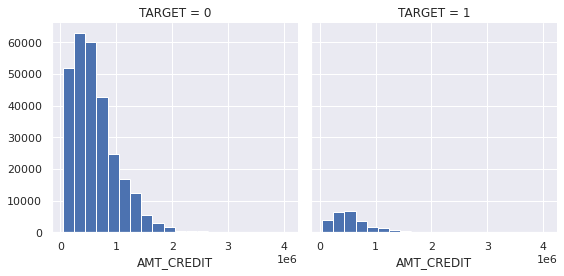

In [22]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT', bins=20)

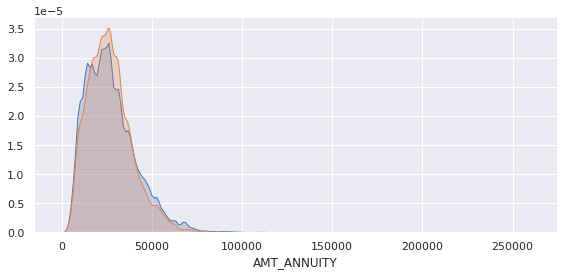

In [23]:
# 1年間で返済しているローン額
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_ANNUITY', shade=True)

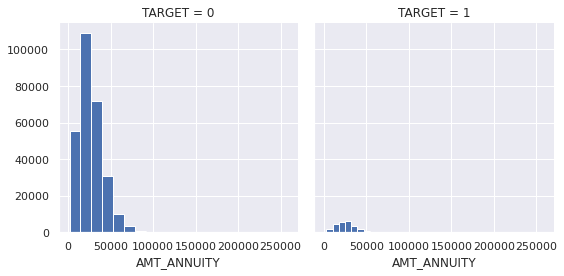

In [24]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_ANNUITY', bins=20)

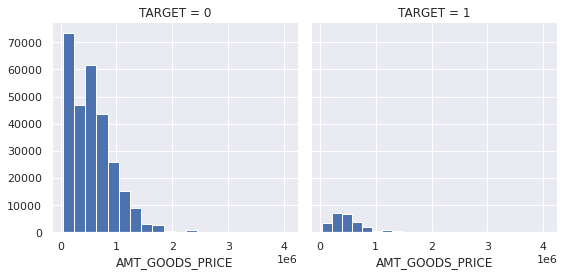

In [25]:
# ローンで購入する物の価格
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_GOODS_PRICE', bins=20)

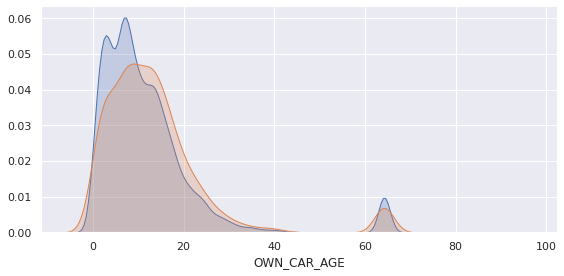

In [26]:
# 現在の車を購入してから経過した年
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'OWN_CAR_AGE', shade=True)

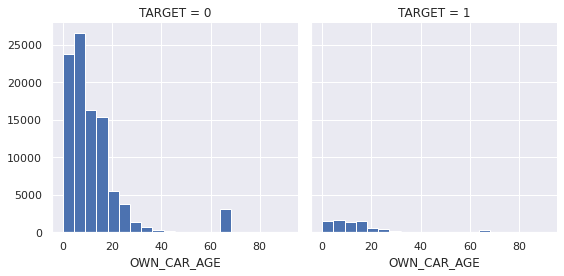

In [27]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'OWN_CAR_AGE', bins=20)

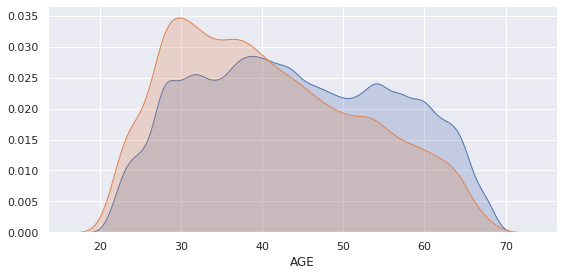

In [28]:
# 年齢
train['AGE'] = train['DAYS_BIRTH'] / 365 * (-1)
test['AGE'] = test['DAYS_BIRTH'] / 365 * (-1)

train = train.drop('DAYS_BIRTH', axis=1)
test = test.drop('DAYS_BIRTH', axis=1)

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AGE', shade=True)

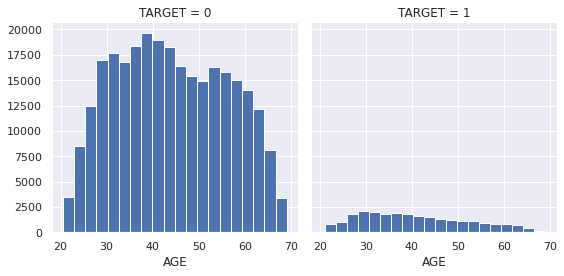

In [29]:
grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AGE', bins=20)

<AxesSubplot:xlabel='NAME_TYPE_SUITE', ylabel='count'>

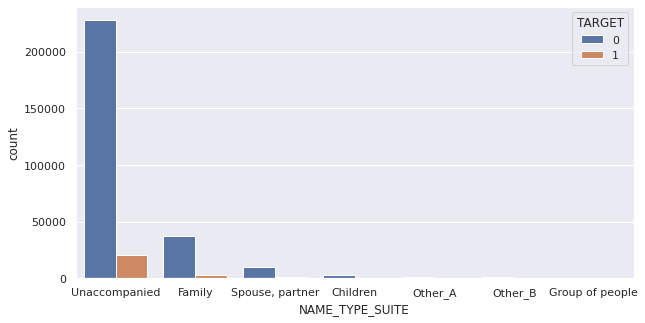

In [30]:
# ローン申し込み時の同伴者
plt.figure(figsize=(10, 5))
sns.countplot(x='NAME_TYPE_SUITE', data=train, hue='TARGET')

<AxesSubplot:xlabel='NAME_INCOME_TYPE', ylabel='count'>

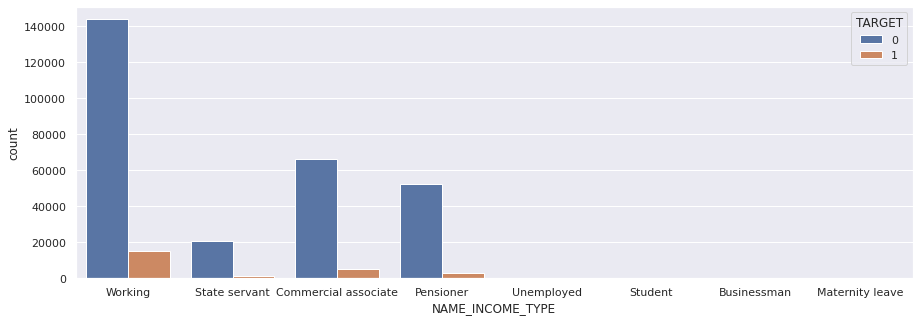

In [31]:
# 収入のタイプ
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_INCOME_TYPE', data=train, hue='TARGET')

<AxesSubplot:xlabel='NAME_FAMILY_STATUS', ylabel='count'>

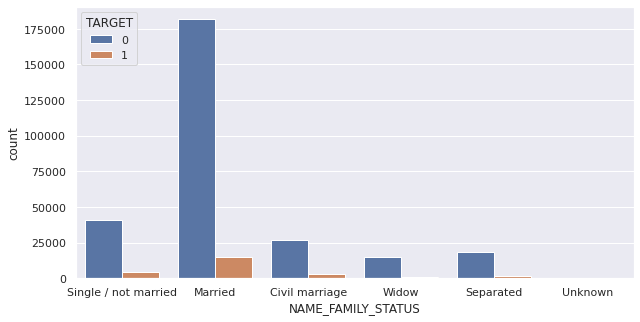

In [32]:
# 結婚の有無
plt.figure(figsize=(10, 5))
sns.countplot(x='NAME_FAMILY_STATUS', data=train, hue='TARGET')

<AxesSubplot:xlabel='NAME_HOUSING_TYPE', ylabel='count'>

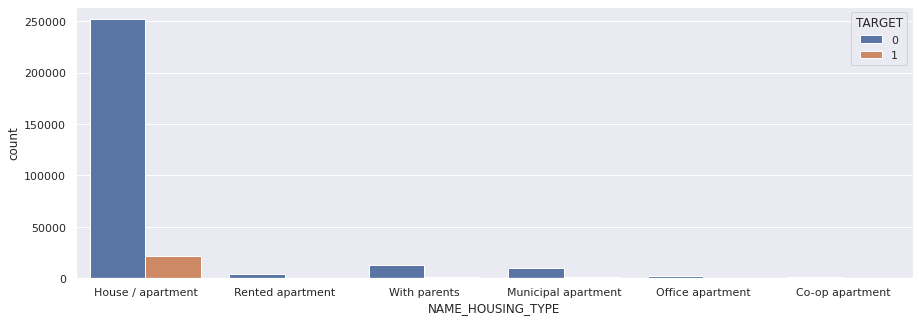

In [33]:
# 住居のタイプ
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_HOUSING_TYPE', data=train, hue='TARGET')

<AxesSubplot:xlabel='NAME_EDUCATION_TYPE', ylabel='count'>

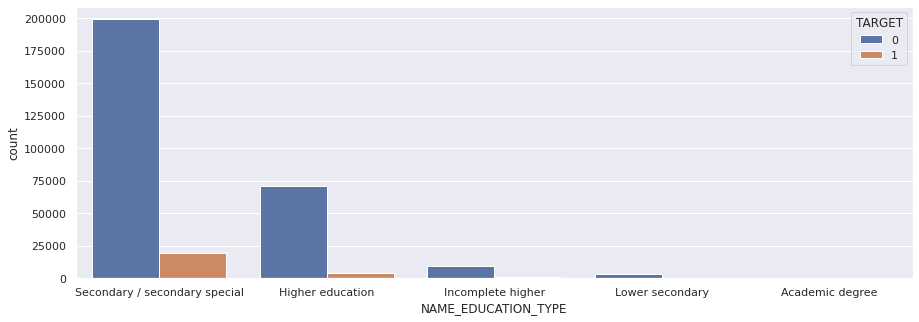

In [34]:
# 最終学歴
plt.figure(figsize=(15, 5))
sns.countplot(x='NAME_EDUCATION_TYPE', data=train, hue='TARGET')

0      -637
1     -1188
2      -225
3     -3039
4     -3038
5     -1588
6     -3130
7      -449
8    365243
9     -2019
Name: DAYS_EMPLOYED, dtype: int64


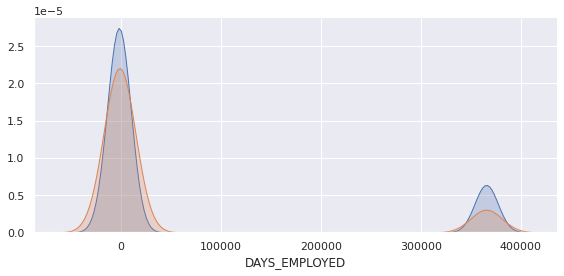

In [35]:
# 現在の仕事に就いてからローンを申し込むまでの日数
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'DAYS_EMPLOYED', shade=True)

print(train['DAYS_EMPLOYED'][:10])

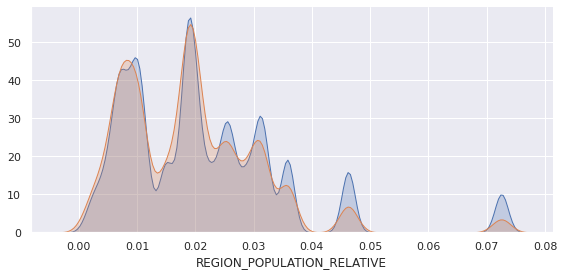

In [36]:
# 住んでいる地域の人口
fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'REGION_POPULATION_RELATIVE', shade=True)

<AxesSubplot:xlabel='count', ylabel='ORGANIZATION_TYPE'>

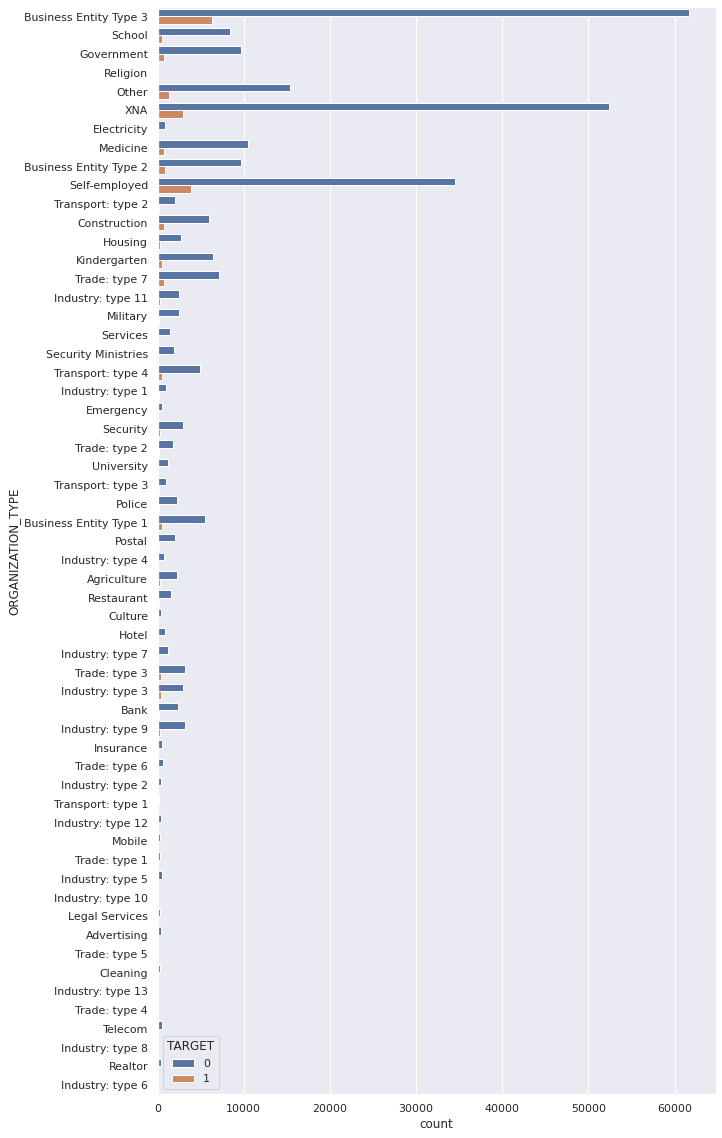

In [37]:
# 仕事の業界
plt.figure(figsize=(10, 20))
sns.countplot(y='ORGANIZATION_TYPE', data=train, hue='TARGET')

<AxesSubplot:xlabel='count', ylabel='OCCUPATION_TYPE'>

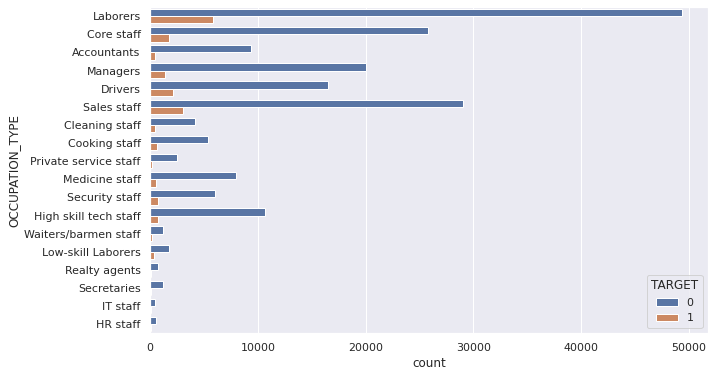

In [38]:
# 仕事の職種
plt.figure(figsize=(10, 6))
sns.countplot(y='OCCUPATION_TYPE', data=train, hue='TARGET')

<AxesSubplot:xlabel='CNT_FAM_MEMBERS', ylabel='count'>

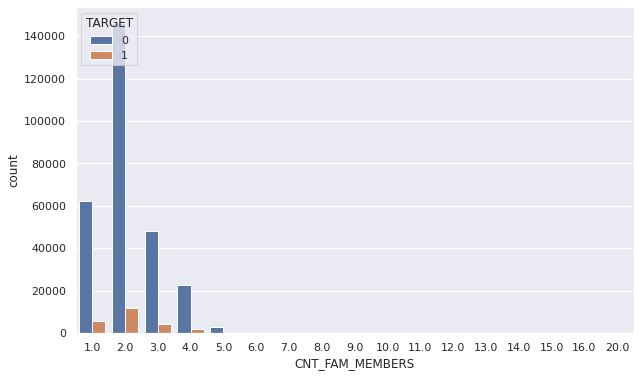

In [39]:
# 家族人数
plt.figure(figsize=(10, 6))
sns.countplot(x='CNT_FAM_MEMBERS', data=train, hue='TARGET')

# Outliers

正確なデータの分布を見るために、外れ値は欠損値に置き換えて可視化する。

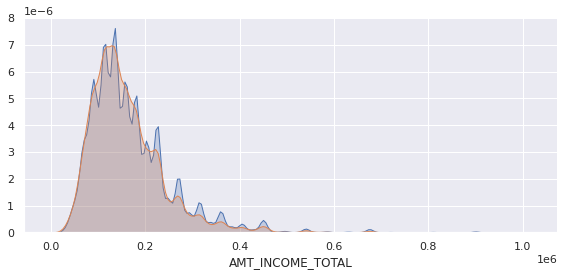

In [40]:
# 1年間のトータル収入
def INCOME_EDIT(x):
    if x >= 1000000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_INCOME_TOTAL'] = train['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_EDIT(x))
test['AMT_INCOME_TOTAL'] = test['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_EDIT(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_INCOME_TOTAL', shade=True)

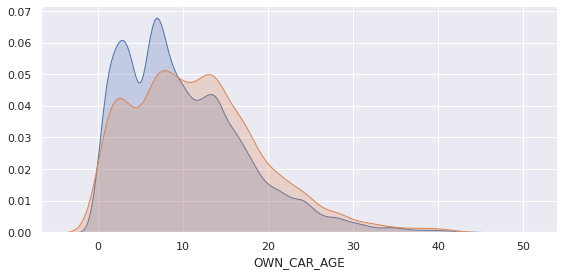

In [41]:
# 現在の車を購入してから経過した年
def CAR_transformer(x):
    if x >= 50:
        y = np.nan
    else:
        y = x
    return y

train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].apply(lambda x: CAR_transformer(x))
test['OWN_CAR_AGE'] = test['OWN_CAR_AGE'].apply(lambda x: CAR_transformer(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'OWN_CAR_AGE', shade=True)

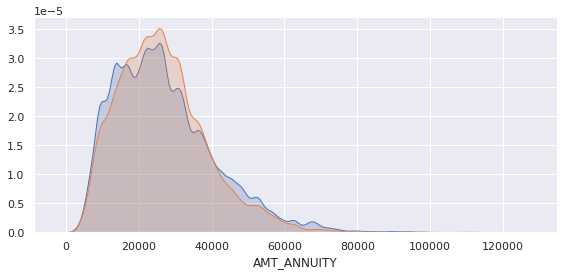

In [42]:
# 1年間で返済しているローン額
def ANNUITY_EDIT(x):
    if x >= 125000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_ANNUITY'] = train['AMT_ANNUITY'].apply(lambda x: ANNUITY_EDIT(x))
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].apply(lambda x: ANNUITY_EDIT(x))

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'AMT_ANNUITY', shade=True)

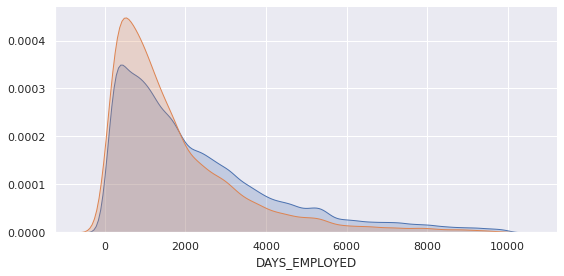

In [43]:
# 現職に就いてからローンを申し込むまでの日数
def EMPLOYED_EDIT(x):
    if x >= 0:
        y = np.nan
    elif x <= -10000:
        y = np.nan
    else:
        y = x
    return y

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: EMPLOYED_EDIT(x))
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'] * (-1)

test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: EMPLOYED_EDIT(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'] * (-1)

fig = sns.FacetGrid(train, hue='TARGET', height=4, aspect=2)
fig.map(sns.kdeplot, 'DAYS_EMPLOYED', shade=True)

# Feature Engneering

特徴量を作成する上で、欠損値を埋める必要があるものは、先に補完する。<br>
外れ値を除けていないカラムもあるため、平均ではなく中央値での補完を採用する。

<AxesSubplot:xlabel='CNT_CHILDREN_CLASSIFICATION', ylabel='count'>

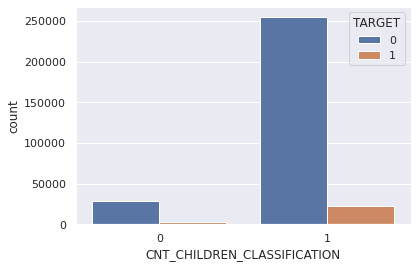

In [44]:
# 子供の人数
def CHILDREN_transformer(x):
    if x <= 1:
        y = 1
    else:
        y = 0
    return y

train['CNT_CHILDREN_CLASSIFICATION'] = train['CNT_CHILDREN'].apply(lambda x: CHILDREN_transformer(x))
test['CNT_CHILDREN_CLASSIFICATION'] = test['CNT_CHILDREN'].apply(lambda x: CHILDREN_transformer(x))

sns.countplot(x='CNT_CHILDREN_CLASSIFICATION', data=train, hue='TARGET')

<AxesSubplot:xlabel='AMT_INCOME_RANK', ylabel='count'>

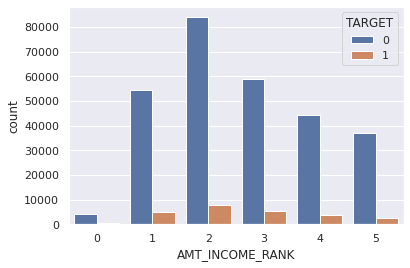

In [45]:
# 1年間のトータル収入
train['AMT_INCOME_TOTAL'] = train['AMT_INCOME_TOTAL'].fillna(train['AMT_INCOME_TOTAL'].median())
test['AMT_INCOME_TOTAL'] = test['AMT_INCOME_TOTAL'].fillna(test['AMT_INCOME_TOTAL'].median())

def INCOME_RANK(x):
    if x <= 50000:
        y = 0
    elif x <= 100000:
        y = 1
    elif x <= 150000:
        y = 2
    elif x <= 200000:
        y = 3
    elif x <= 250000:
        y = 4
    else:
        y = 5
    return y

train['AMT_INCOME_RANK'] = train['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_RANK(x))
test['AMT_INCOME_RANK'] = test['AMT_INCOME_TOTAL'].apply(lambda x: INCOME_RANK(x))

sns.countplot(x='AMT_INCOME_RANK', data=train, hue='TARGET')

<AxesSubplot:xlabel='AMT_INCOME_RANK_CLASS', ylabel='count'>

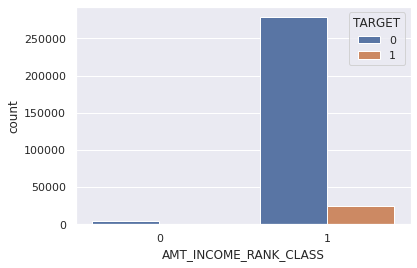

In [46]:
def INCOME_transformer(x):
    if x >= 1:
        y = 1
    else:
        y = 0
    return y

train['AMT_INCOME_RANK_CLASS'] = train['AMT_INCOME_RANK'].apply(lambda x: INCOME_transformer(x))
train = train.drop('AMT_INCOME_RANK', axis=1)

test['AMT_INCOME_RANK_CLASS'] = test['AMT_INCOME_RANK'].apply(lambda x: INCOME_transformer(x))
test = test.drop('AMT_INCOME_RANK', axis=1)

sns.countplot(x='AMT_INCOME_RANK_CLASS', data=train, hue='TARGET')

<AxesSubplot:xlabel='AMT_CREDIT_CLASS', ylabel='count'>

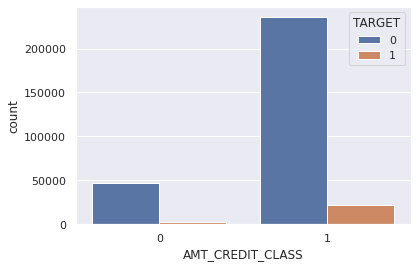

In [47]:
# ローン総額
def CREDIT_transformer(x):
    if x <= 1000000:
        y = 1
    else:
        y = 0
    return y

train['AMT_CREDIT_CLASS'] = train['AMT_CREDIT'].apply(lambda x: CREDIT_transformer(x))
test['AMT_CREDIT_CLASS'] = test['AMT_CREDIT'].apply(lambda x: CREDIT_transformer(x))

sns.countplot(x='AMT_CREDIT_CLASS', data=train, hue='TARGET')

<AxesSubplot:xlabel='AMT_ANNUITY_CLASS', ylabel='count'>

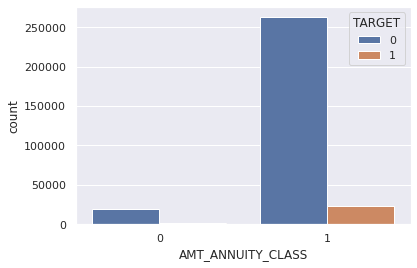

In [48]:
# 1年間に支払うローン額
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].fillna(test['AMT_ANNUITY'].median())

def ANNUITY_transformer(x):
    if x <= 50000:
        y = 1
    else:
        y = 0
    return y

train['AMT_ANNUITY_CLASS'] = train['AMT_ANNUITY'].apply(lambda x: ANNUITY_transformer(x))
test['AMT_ANNUITY_CLASS'] = test['AMT_ANNUITY'].apply(lambda x: ANNUITY_transformer(x))

sns.countplot(x='AMT_ANNUITY_CLASS', data=train, hue='TARGET')

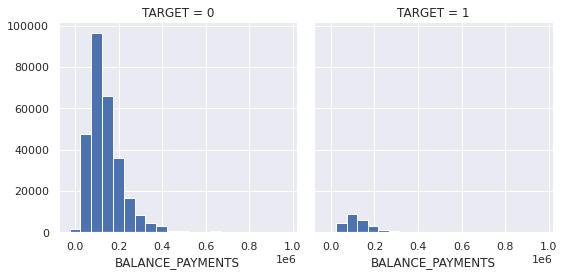

In [49]:
# 1年間の収入 - 1年間に支払うローン額
train['BALANCE_PAYMENTS'] = train['AMT_INCOME_TOTAL'] - train['AMT_ANNUITY']
test['BALANCE_PAYMENTS'] = test['AMT_INCOME_TOTAL'] - test['AMT_ANNUITY']

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'BALANCE_PAYMENTS', bins=20)

<AxesSubplot:xlabel='BALANCE_PAYMENTS_CLASS', ylabel='count'>

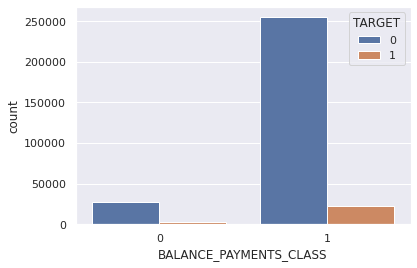

In [50]:
def BALANCE_transformer(x):
    if x >= 60000:
        y = 1
    else:
        y = 0
    return y

train['BALANCE_PAYMENTS_CLASS'] = train['BALANCE_PAYMENTS'].apply(lambda x: BALANCE_transformer(x))
test['BALANCE_PAYMENTS_CLASS'] = test['BALANCE_PAYMENTS'].apply(lambda x: BALANCE_transformer(x))

sns.countplot(x='BALANCE_PAYMENTS_CLASS', data=train, hue='TARGET')

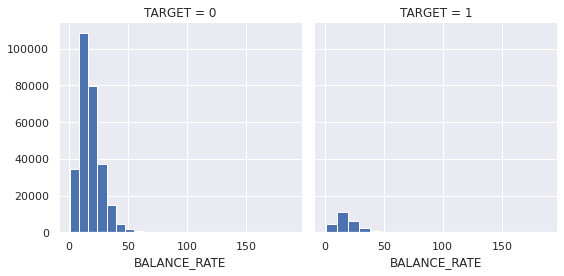

In [51]:
# 1年間に支払うローン額 / 1年間の収入 * 100
train['BALANCE_RATE'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] * 100
test['BALANCE_RATE'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL'] * 100

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'BALANCE_RATE', bins=20)

<AxesSubplot:xlabel='AMT_GOODS_PRICE_CLASS', ylabel='count'>

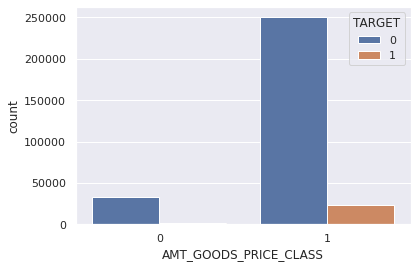

In [52]:
train['AMT_GOODS_PRICE'] = train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].median())
test['AMT_GOODS_PRICE'] = test['AMT_GOODS_PRICE'].fillna(test['AMT_GOODS_PRICE'].median())

def GOODS_transformer(x):
    if x <= 1000000:
        y = 1
    else:
        y = 0
    return y

train['AMT_GOODS_PRICE_CLASS'] = train['AMT_GOODS_PRICE'].apply(lambda x: GOODS_transformer(x))
test['AMT_GOODS_PRICE_CLASS'] = test['AMT_GOODS_PRICE'].apply(lambda x: GOODS_transformer(x))

sns.countplot(x='AMT_GOODS_PRICE_CLASS', data=train, hue='TARGET')

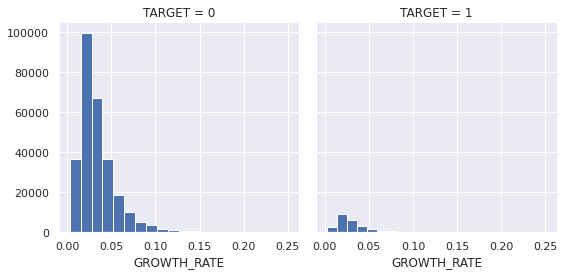

In [53]:
# 年齢 / 1年間の収入 * 100
train['GROWTH_RATE'] = train['AGE'] / train['AMT_INCOME_TOTAL'] * 100
test['GROWTH_RATE'] = test['AGE'] / test['AMT_INCOME_TOTAL'] * 100

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'GROWTH_RATE', bins=20)

<AxesSubplot:xlabel='GROWTH_RATE_CLASS', ylabel='count'>

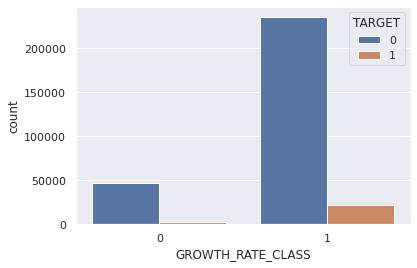

In [54]:
train['GROWTH_RATE'] = train['GROWTH_RATE'].fillna(train['GROWTH_RATE'].median())
test['GROWTH_RATE'] = test['GROWTH_RATE'].fillna(test['GROWTH_RATE'].median())

def Growth_transformer(x):
    if x <= 0.05:
        y = 1
    else:
        y = 0
    return y

train['GROWTH_RATE_CLASS'] = train['GROWTH_RATE'].apply(lambda x: Growth_transformer(x))
test['GROWTH_RATE_CLASS'] = test['GROWTH_RATE'].apply(lambda x: Growth_transformer(x))

sns.countplot(x='GROWTH_RATE_CLASS', data=train, hue='TARGET')

<AxesSubplot:xlabel='PARENTS', ylabel='count'>

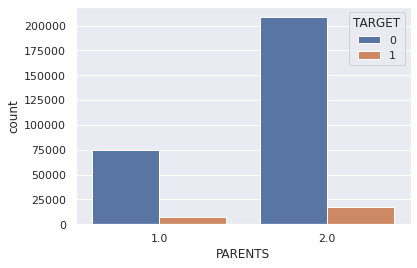

In [55]:
# 育て親の人数（家族人数 - 子供の人数）
train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].median())
test['CNT_FAM_MEMBERS'] = test['CNT_FAM_MEMBERS'].fillna(test['CNT_FAM_MEMBERS'].median())

train['PARENTS'] = train['CNT_FAM_MEMBERS'] - train['CNT_CHILDREN']
test['PARENTS'] = test['CNT_FAM_MEMBERS'] - test['CNT_CHILDREN']

sns.countplot(x='PARENTS', data=train, hue='TARGET')

<AxesSubplot:xlabel='CAR_AND_REALTY', ylabel='count'>

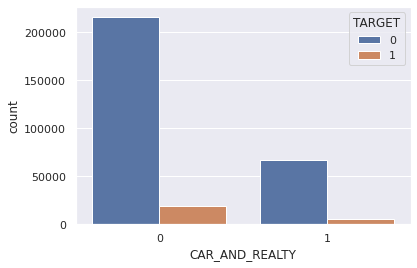

In [56]:
# 車所有かつ家を持っている（0：No、1：Yes）
def OWN_transformer(x):
    if x == 'Y':
        y = 1
    else:
        y = 0
    return y

train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].apply(lambda x: OWN_transformer(x))
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].apply(lambda x: OWN_transformer(x))
train['CAR_AND_REALTY'] = train['FLAG_OWN_CAR'] * train['FLAG_OWN_REALTY']

test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].apply(lambda x: OWN_transformer(x))
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].apply(lambda x: OWN_transformer(x))
test['CAR_AND_REALTY'] = test['FLAG_OWN_CAR'] * test['FLAG_OWN_REALTY']

sns.countplot(x='CAR_AND_REALTY', data=train, hue='TARGET')

<AxesSubplot:xlabel='SINGLE_FEMAIL_PARENTS', ylabel='count'>

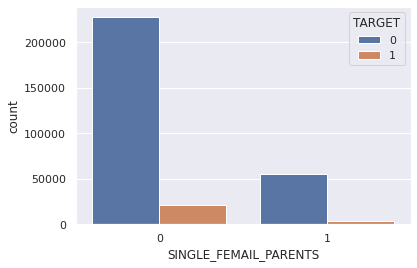

In [57]:
# 女性かつ1人親（0：No、1：Yes）
def Female_transformer(x):
    if x == 'F':
        y = 1
    else:
        y = 0
    return y

def Single_transformer(x):
    if x == 1:
        y = 1
    else:
        y = 0
    return y

train['FEMAIL'] = train['CODE_GENDER'].apply(lambda x: Female_transformer(x))
train['SINGLE_PARENTS'] = train['PARENTS'].apply(lambda x: Single_transformer(x))
train['SINGLE_FEMAIL_PARENTS'] = train['FEMAIL'] * train['SINGLE_PARENTS']
train = train.drop(['FEMAIL', 'SINGLE_PARENTS'], axis=1)

test['FEMAIL'] = test['CODE_GENDER'].apply(lambda x: Female_transformer(x))
test['SINGLE_PARENTS'] = test['PARENTS'].apply(lambda x: Single_transformer(x))
test['SINGLE_FEMAIL_PARENTS'] =test['FEMAIL'] * test['SINGLE_PARENTS']
test = test.drop(['FEMAIL', 'SINGLE_PARENTS'], axis=1)

sns.countplot(x='SINGLE_FEMAIL_PARENTS', data=train, hue='TARGET')

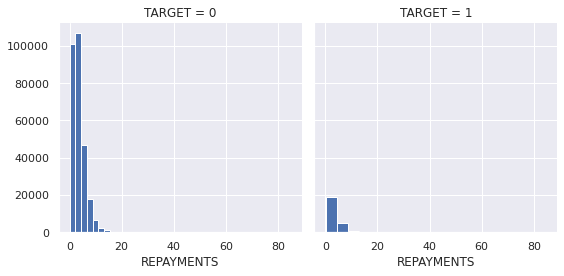

In [58]:
# ローンを借りて購入する物の価格 / 1年間の年収
train['REPAYMENTS'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']
test['REPAYMENTS'] = test['AMT_GOODS_PRICE'] / test['AMT_INCOME_TOTAL']

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'REPAYMENTS', bins=20)

<AxesSubplot:xlabel='REPAYMENTS_CLASS', ylabel='count'>

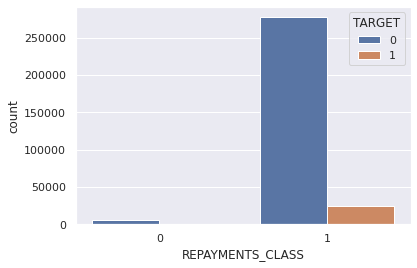

In [59]:
def Repayment_transformer(x):
    if x <= 10:
        y = 1
    else:
        y = 0
    return y

train['REPAYMENTS_CLASS'] = train['REPAYMENTS'].apply(lambda x: Repayment_transformer(x))
test['REPAYMENTS_CLASS'] = test['REPAYMENTS'].apply(lambda x: Repayment_transformer(x))

sns.countplot(x='REPAYMENTS_CLASS', data=train, hue='TARGET')

In [60]:
# ローンの申請回数
Application_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'APPLICATION_COUNTS'})
Application_counts.head(10)

,SK_ID_CURR,APPLICATION_COUNTS
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
5,100007,1
6,100008,3
7,100009,18
8,100010,2
9,100011,4


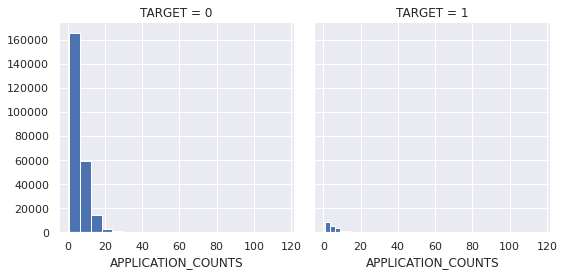

In [61]:
train = pd.merge(train, Application_counts, on='SK_ID_CURR', how='left')
test = pd.merge(test, Application_counts, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'APPLICATION_COUNTS', bins=20)

In [62]:
# CREDIT_ACTIVE = activeになっている回数
def CREDIT_ACTIVE_transformer(x):
    if x == 'Active':
        y = 1
    else:
        y = 0
    return y

bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].apply(lambda x: CREDIT_ACTIVE_transformer(x))

Credit_counts = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].sum()
pd.DataFrame(Credit_counts).head(10)

,CREDIT_ACTIVE
SK_ID_CURR,
100001,3
100002,2
100003,1
100004,0
100005,2
100007,0
100008,1
100009,4
100010,1


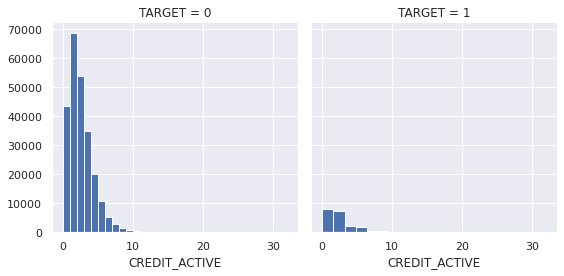

In [63]:
train = pd.merge(train, Credit_counts, on='SK_ID_CURR', how='left')
test = pd.merge(test, Credit_counts, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'CREDIT_ACTIVE', bins=20)

In [64]:
# AMT_CREDIT_SUMの平均
AMT_CREDIT_SUM_MEAN = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM'].mean().rename(columns={'AMT_CREDIT_SUM': 'AMT_CREDIT_SUM_MEAN'})
AMT_CREDIT_SUM_MEAN.head(10)

,SK_ID_CURR,AMT_CREDIT_SUM_MEAN
0,100001,207623.571429
1,100002,108131.945625
2,100003,254350.125000
3,100004,94518.900000
4,100005,219042.000000
5,100007,146250.000000
6,100008,156148.500000
7,100009,266711.750000
8,100010,495000.000000
9,100011,108807.075000


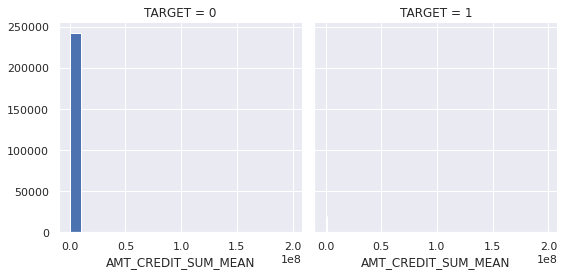

In [65]:
train = pd.merge(train, AMT_CREDIT_SUM_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_CREDIT_SUM_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT_SUM_MEAN', bins=20)

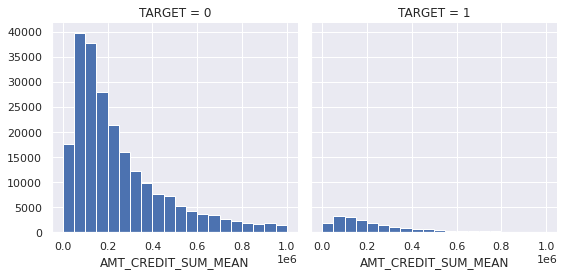

In [66]:
def CREDIT_SUM_MEAN_transformer(x):
    if x >= 1000000:
        y = np.nan
    else:
        y = x
    return y

train['AMT_CREDIT_SUM_MEAN'] = train['AMT_CREDIT_SUM_MEAN'].apply(lambda x: CREDIT_SUM_MEAN_transformer(x))
test['AMT_CREDIT_SUM_MEAN'] = test['AMT_CREDIT_SUM_MEAN'].apply(lambda x: CREDIT_SUM_MEAN_transformer(x))

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_CREDIT_SUM_MEAN', bins=20)

In [67]:
# AMT_BALANCEの平均
AMT_BALANCE_MEAN = ccb.groupby('SK_ID_CURR', as_index=False)['AMT_BALANCE'].mean().rename(columns={'AMT_BALANCE': 'AMT_BALANCE_MEAN'})
AMT_BALANCE_MEAN.head(10)

,SK_ID_CURR,AMT_BALANCE_MEAN
0,100006,0.000000
1,100011,54482.111149
2,100013,18159.919219
3,100021,0.000000
4,100023,0.000000
5,100028,8085.058163
6,100036,0.000000
7,100042,33356.183036
8,100043,208572.600000
9,100047,0.000000


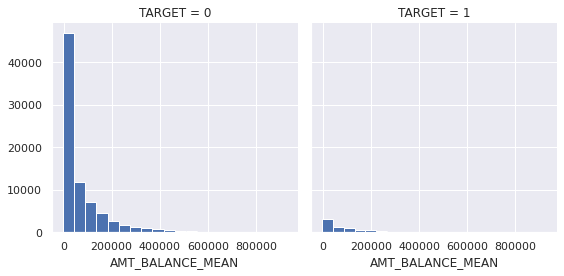

In [68]:
train = pd.merge(train, AMT_BALANCE_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_BALANCE_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_BALANCE_MEAN', bins=20)

In [69]:
# AMT_TOTAL_RECEIVABLEの平均
AMT_TOTAL_RECEIVABLE_MEAN = ccb.groupby('SK_ID_CURR', as_index=False)['AMT_TOTAL_RECEIVABLE'].mean().rename(columns={'AMT_TOTAL_RECEIVABLE': 'AMT_TOTAL_RECEIVABLE_MEAN'})
AMT_TOTAL_RECEIVABLE_MEAN.head(10)

,SK_ID_CURR,AMT_TOTAL_RECEIVABLE_MEAN
0,100006,0.000000
1,100011,54433.179122
2,100013,18101.079844
3,100021,0.000000
4,100023,0.000000
5,100028,7968.609184
6,100036,0.000000
7,100042,33298.140000
8,100043,208397.449091
9,100047,0.000000


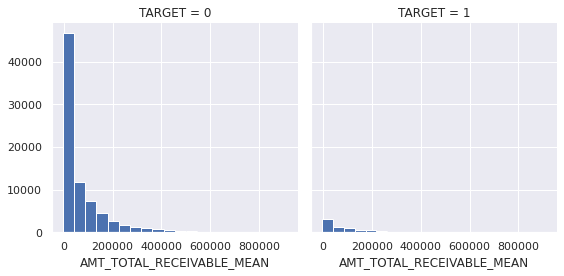

In [70]:
train = pd.merge(train, AMT_TOTAL_RECEIVABLE_MEAN, on='SK_ID_CURR', how='left')
test = pd.merge(test, AMT_TOTAL_RECEIVABLE_MEAN, on='SK_ID_CURR', how='left')

grid = sns.FacetGrid(train, col='TARGET', height=4, aspect=1)
grid.map(plt.hist, 'AMT_TOTAL_RECEIVABLE_MEAN', bins=20)

# Preprocess

[機械学習アルゴリズム選択ガイド](https://blogs.sas.com/content/sasjapan/2017/11/21/machine-learning-algorithm-use/)を参考に、予測の正確性を最優先とし、以下のモデルを試していく。

・RandomForest：✕（スコアが低かったため、不採用とする）<br>
・LightGBM：○<br>
・XGBoost：これから検証<br>
・SupportVectorMachine：これから検証

決定木をベースとしたモデルであるため、欠損値の補完は特に行わなくても良いが<br>
補完を行った場合の方がスコアが0.01ほど高くなったため、処理を行っている。

尚、決定木をベースとしたモデルに対して、欠損値であると認識させるために<br>
数値データの補完は、-9999という通常取り得る範囲外の値を用いている。

In [71]:
X_train = train[[col for col in train.columns if col != 'TARGET']]
y_train = train['TARGET']
X_test = test

X = pd.concat([X_train, X_test], axis=0)
X = X.drop('SK_ID_CURR', axis=1)

print(X.shape)

(356255, 140)


In [72]:
numerical_col = [col for col in X.columns if X[col].dtype != 'object']
categorical_col = [col for col in X.columns if X[col].dtype == 'object']

X_num = X[numerical_col]
X_cat = X[categorical_col]

In [73]:
X_num = X_num.fillna(-9999)
X_cat = X_cat.fillna(value='missing')
X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_num, X_cat], axis=1)

In [74]:
train_rows = train.shape[0]
X_train = X[:train_rows]
X_test = X[train_rows:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(307511, 268)
(307511,)
(48744, 268)


# Modeling

今回はベイズ最適化を利用したOptunaでのパラメータチューニングを行う。<br>
正確性と速さのバランスが優れているため使用しているが、他のチューニング方法についても随時検討していきたい。

In [75]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [76]:
'''
def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = xgb.XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

"\ndef create_model(trial):\n    n_estimators = trial.suggest_int('n_estimators', 50, 500)\n    max_depth = trial.suggest_int('max_depth', 3, 8)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = xgb.XGBClassifier(\n        n_estimators=n_estimators, \n        max_depth=max_depth, \n        learning_rate=learning_rate,\n        subsample=subsample,\n        colsample_bytree=colsample_bytree,\n        random_state=666)\n        \n    return model\n\ndef objective(trial):\n    model = create_model(trial)\n    model.fit(X_tr, y_tr)\n    y_proba = model.predict_proba(X_val)[:,1]\n    score = roc_auc_score(y_val, y_proba)\n    return score\n\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=40)\nparams = study.best_params\n\nprint(params)\n\n"

In [77]:
params = {'n_estimators': 496,
          'max_depth': 4, 
          'learning_rate': 0.052819174028842786, 
          'subsample': 0.8699406829181138,
          'colsample_bytree': 0.6127121392595005,
          'random_state': 666}

In [78]:
%%time

cls = xgb.XGBClassifier(**params)
cls.fit(X_train, y_train)

y_proba = cls.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 25min 24s, sys: 2.65 s, total: 25min 27s
Wall time: 6min 32s


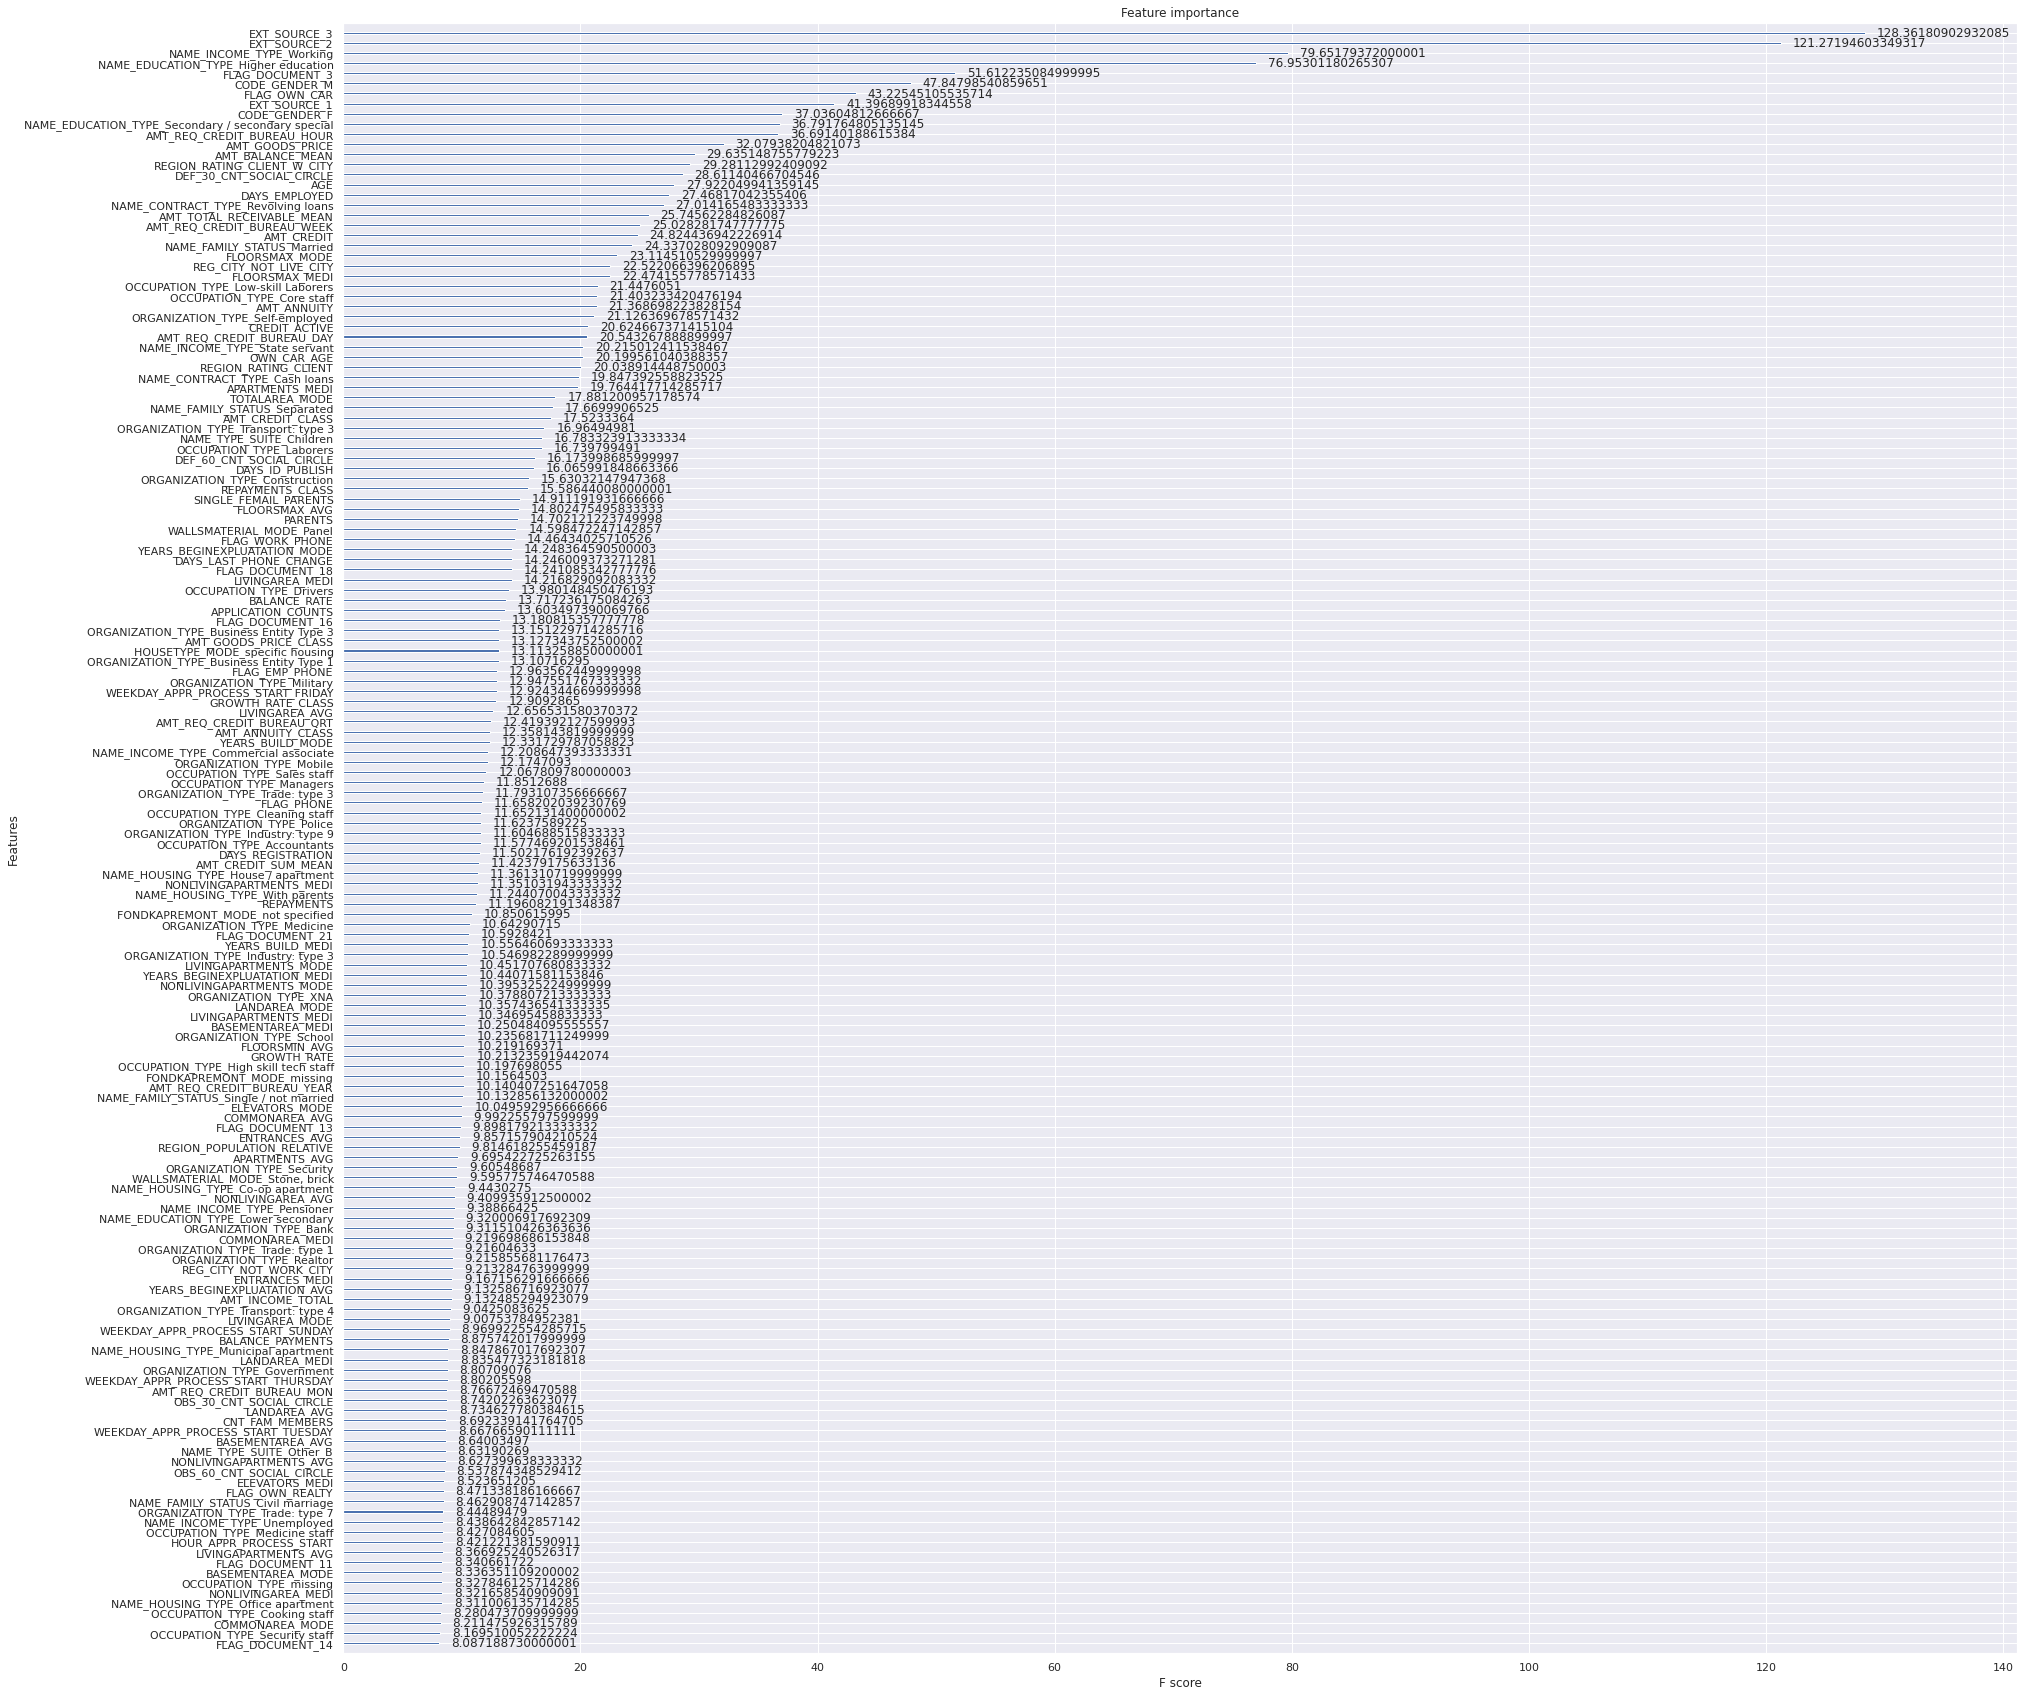

In [79]:
fig,ax = plt.subplots(figsize=(30,30))
xgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=160)
plt.show()

# Submit

データの予測値が得られたので、これをコンペティション主催に提出（Submit）する。<br>
正解データと照らし合わせて、どの程度合っていたかをスコアとして受け取る。

In [80]:
submit = pd.DataFrame(y_proba, index=test['SK_ID_CURR'], columns=['TARGET'])
submit.to_csv('home_credit_submit.csv')

submit.head(10)

,TARGET
SK_ID_CURR,
100001,0.037562
100005,0.109174
100013,0.027450
100028,0.032614
100038,0.150621
100042,0.069821
100057,0.017209
100065,0.034287
100066,0.007951
